#### Professor given code (skip to next cell for Task )

  Cloning https://github.com/pantelis-classes/PRML.git to /tmp/pip-install-mtx87v5e/prml_7c2bc0a9efe7430bbc6108838f6cf35a
  Running command git clone --filter=blob:none --quiet https://github.com/pantelis-classes/PRML.git /tmp/pip-install-mtx87v5e/prml_7c2bc0a9efe7430bbc6108838f6cf35a
  Resolved https://github.com/pantelis-classes/PRML.git to commit 6c7ef85da419a644a4a4feb7ab538d2f4f15d46b
  Preparing metadata (setup.py) ... done
  Created wheel for prml: filename=prml-0.0.1-py3-none-any.whl size=88378 sha256=344cfd7ff7a020539ae38d8d6afec141a820c52f7e31d23213679b541ddce507
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdetii_i/wheels/b7/84/3a/3fe6b906f543b530ffc903293298b0daf944cc2ba034713156
Successfully built prml


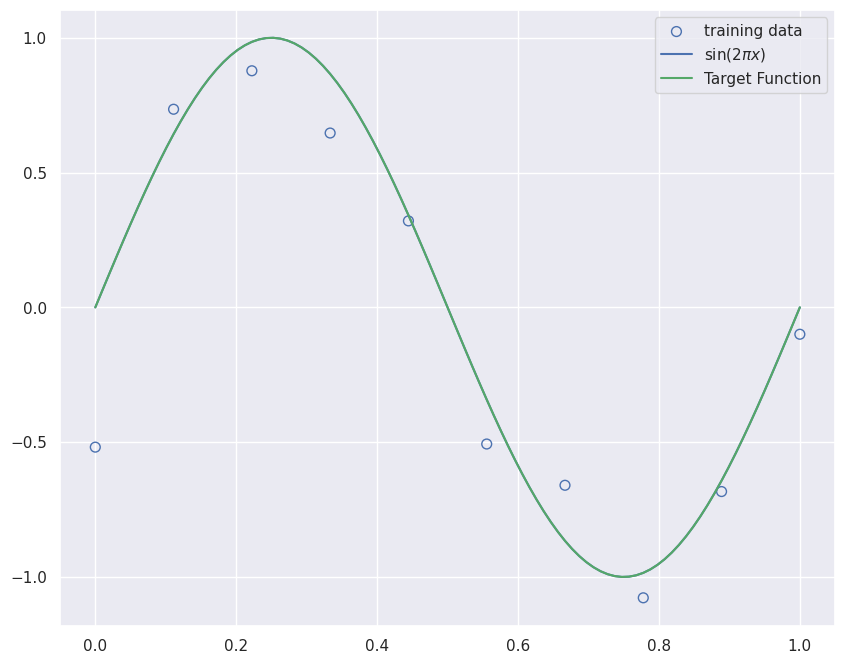

In [2]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml

import seaborn as sns

# Apply the default theme
sns.set_theme()
import seaborn as sns

# Apply the default theme
sns.set_theme()

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)

np.random.seed(1234)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

#### Task 1: Stochastic Gradient Descent

1. Linear model equation:
   $y = wx + b$

   Where $w$ is the weight and $b$ is the bias.

2. Mean Squared Error (MSE) loss function:
   $\text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_{\text{pred},i} - y_{\text{true},i})^2$

3. Gradient of MSE with respect to weight:
   $\frac{\partial \text{MSE}}{\partial w} = \frac{2}{n}\sum_{i=1}^n (y_{\text{pred},i} - y_{\text{true},i})x_i$

4. Gradient of MSE with respect to bias:
   $\frac{\partial \text{MSE}}{\partial b} = \frac{2}{n}\sum_{i=1}^n (y_{\text{pred},i} - y_{\text{true},i})$

5. Weight update rule (Stochastic Gradient Descent):
   $w_{\text{new}} = w_{\text{old}} - \alpha \frac{\partial \text{MSE}}{\partial w}$

   Where $\alpha$ is the learning rate.

6. Bias update rule (Stochastic Gradient Descent):
   $b_{\text{new}} = b_{\text{old}} - \alpha \frac{\partial \text{MSE}}{\partial b}$

These equations represent the core mathematical concepts implemented in the provided code for linear regression using manual gradient descent.

Epoch 0: Loss = 3.5884711742401123
Epoch 100: Loss = 0.20806440711021423
Epoch 200: Loss = 0.1794019341468811


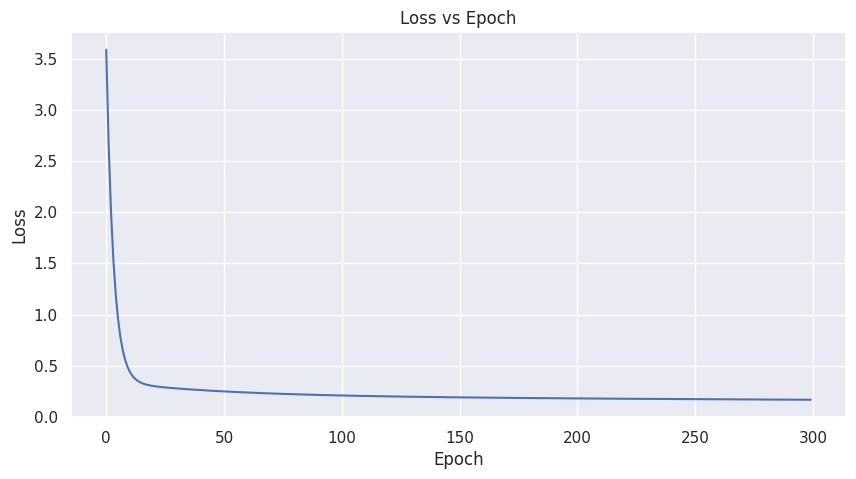

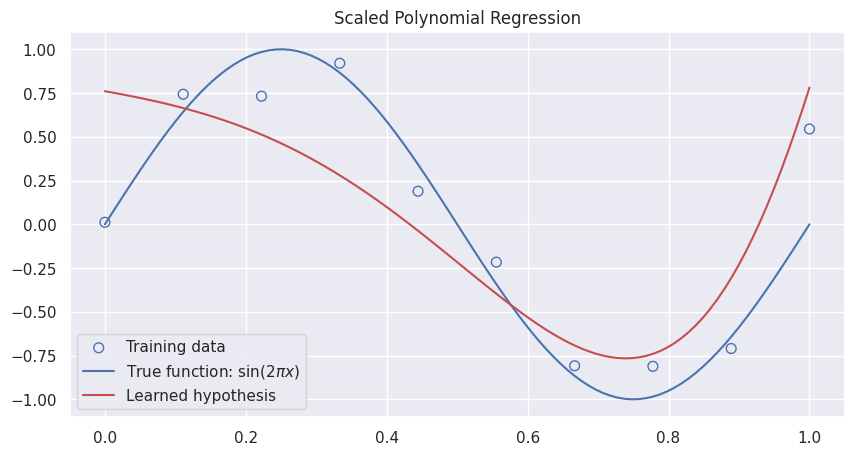

In [19]:
# Required Libraries
import torch
import torch.linalg as linalg
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set a seed for reproducibility
torch.manual_seed(1234)

# Hyperparameters
learning_rate = 0.01
num_epochs = 300
reg_lambda = 0.01  # Regularization parameter
M = 9  # Model complexity

# Dataset creation using a sinusoidal function
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = torch.linspace(domain[0], domain[1], sample_size)
    y = func(x) + torch.randn(x.shape) * std
    return x, y

def sinusoidal(x):
    return torch.sin(2 * torch.pi * x)

# Training and testing datasets
x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = torch.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# Feature transformation (Scaled Polynomial Features)
def scaled_polynomial_features(x, degree):
    features = torch.stack([x**i for i in range(degree + 1)], dim=1)
    # Scale features to have zero mean and unit variance
    mean = features.mean(dim=0)
    std = features.std(dim=0)
    return (features - mean) / (std + 1e-8)  # Add small epsilon to avoid division by zero

# Generate scaled polynomial features for training and testing
X_train = scaled_polynomial_features(x_train, M)
X_test = scaled_polynomial_features(x_test, M)

# Initialize weights (randomly)
weights = torch.randn(M + 1, requires_grad=True)

# Define the model (linear regression using vector operations)
def linear_model(X, weights):
    return X @ weights

# Define loss function (mean squared error with L2 regularization)
def loss_fn(y_pred, y_true, weights, reg_lambda):
    mse_loss = torch.mean((y_pred - y_true)**2)
    l2_reg = reg_lambda * torch.sum(weights**2)
    return mse_loss + l2_reg

# Gradient computation
def compute_gradient(X, y, weights, reg_lambda):
    y_pred = linear_model(X, weights)
    dw = 2 * X.t() @ (y_pred - y) / len(y) + 2 * reg_lambda * weights
    return dw

# Stochastic Gradient Descent (SGD) implementation
losses = []
for epoch in range(num_epochs):
    # Forward pass
    y_pred = linear_model(X_train, weights)
    loss = loss_fn(y_pred, y_train, weights, reg_lambda)

    # Compute gradient
    grad = compute_gradient(X_train, y_train, weights, reg_lambda)

    # Update weights using gradient descent
    with torch.no_grad():
        weights -= learning_rate * grad

    # Save loss for visualization
    losses.append(loss.item())

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

# Plot the loss vs. epoch
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# Plot final hypothesis
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training data")
plt.plot(x_test, y_test, label="True function: $\sin(2\pi x)$")
plt.plot(x_test, linear_model(X_test, weights).detach(), label="Learned hypothesis", color='r')
plt.legend()
plt.title("Scaled Polynomial Regression")
plt.show()

#### Task 2: SGD with Momentum

1. Velocity update for weight:
   $v_w = \beta v_w + \alpha \frac{\partial \text{MSE}}{\partial w}$

2. Velocity update for bias:
   $v_b = \beta v_b + \alpha \frac{\partial \text{MSE}}{\partial b}$

3. Weight update rule:
   $w_{\text{new}} = w_{\text{old}} - v_w$

4. Bias update rule:
   $b_{\text{new}} = b_{\text{old}} - v_b$

Where:
- $v_w$ is the velocity for the weight
- $v_b$ is the velocity for the bias
- $\beta$ is the momentum coefficient (0.9 in the code)
- $\alpha$ is the learning rate (0.001 in the code)
- $\frac{\partial \text{MSE}}{\partial w}$ and $\frac{\partial \text{MSE}}{\partial b}$ are the gradients of the Mean Squared Error with respect to weight and bias, respectively

These equations represent the core mathematical concepts implemented in the SGD with Momentum optimizer in the below given code.

Momentum - Epoch 0: Loss = 1.1933547258377075
Momentum - Epoch 100: Loss = 0.10930076241493225
Momentum - Epoch 200: Loss = 0.09737296402454376


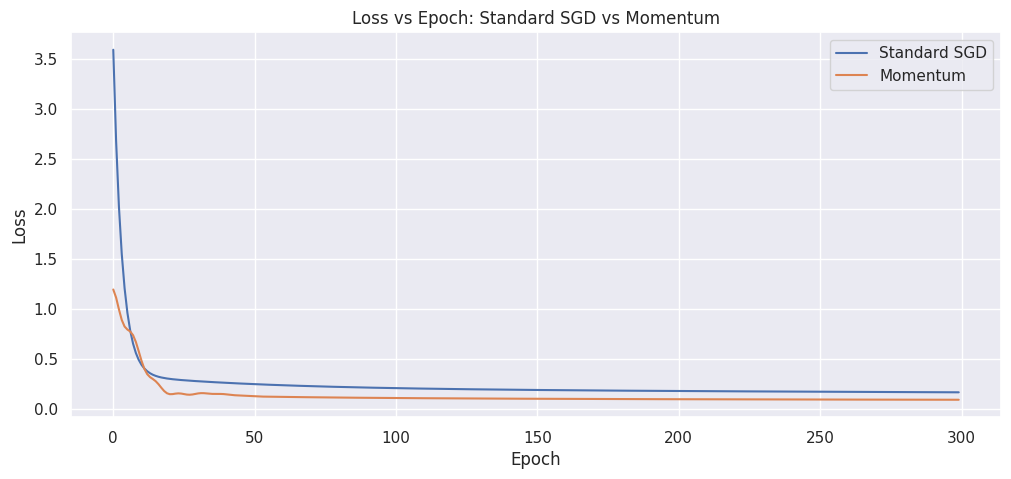

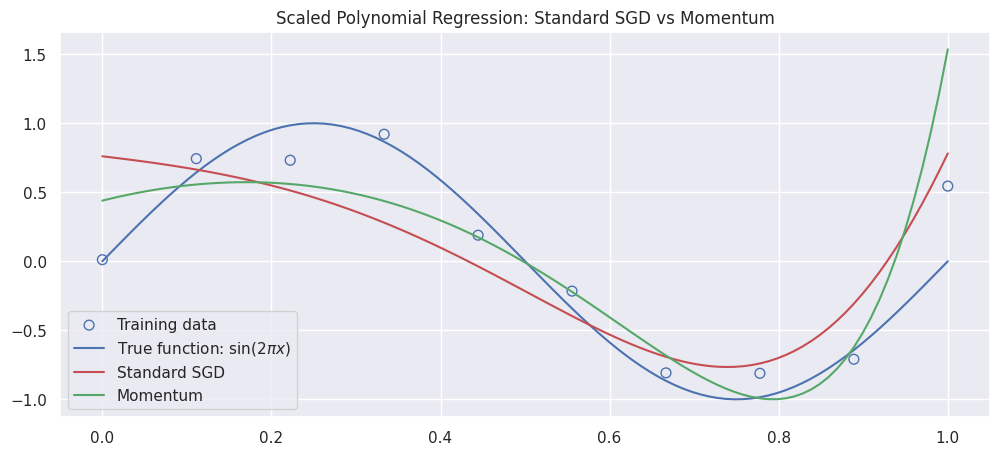

Final loss (Standard SGD): 0.16652588546276093
Final loss (Momentum): 0.09215635806322098


In [20]:
# Hyperparameters for Momentum
momentum = 0.9
learning_rate_momentum = 0.01
num_epochs_momentum = 300

# Initialize weights and velocity for Momentum
weights_momentum = torch.randn(M + 1, requires_grad=False)
velocity = torch.zeros_like(weights_momentum)

# Momentum update function
def momentum_update(weights, velocity, grad, learning_rate, momentum):
    velocity = momentum * velocity + learning_rate * grad
    weights = weights - velocity
    return weights, velocity

# Training loop for Momentum
losses_momentum = []
for epoch in range(num_epochs_momentum):
    # Forward pass
    y_pred = linear_model(X_train, weights_momentum)
    loss = loss_fn(y_pred, y_train, weights_momentum, reg_lambda)

    # Compute gradient
    grad = compute_gradient(X_train, y_train, weights_momentum, reg_lambda)

    # Update weights using momentum
    weights_momentum, velocity = momentum_update(weights_momentum, velocity, grad, learning_rate_momentum, momentum)

    # Save loss for visualization
    losses_momentum.append(loss.item())

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Momentum - Epoch {epoch}: Loss = {loss.item()}')

# Plot the loss vs. epoch for both algorithms
plt.figure(figsize=(12, 5))
plt.plot(losses, label='Standard SGD')
plt.plot(losses_momentum, label='Momentum')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch: Standard SGD vs Momentum")
plt.legend()
plt.show()

# Plot final hypotheses
plt.figure(figsize=(12, 5))
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training data")
plt.plot(x_test, y_test, label="True function: $\sin(2\pi x)$")
plt.plot(x_test, linear_model(X_test, weights).detach(), label="Standard SGD", color='r')
plt.plot(x_test, linear_model(X_test, weights_momentum).detach(), label="Momentum", color='g')
plt.legend()
plt.title("Scaled Polynomial Regression: Standard SGD vs Momentum")
plt.show()

# Print final losses
print(f"Final loss (Standard SGD): {losses[-1]}")
print(f"Final loss (Momentum): {losses_momentum[-1]}")

# Logistic Regression

#### Task 1: Data preprocessing

In [1]:
!pip install kaggle

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = 'ashwinsharmanyu'
os.environ['KAGGLE_KEY'] = 'f85ff71f8504097021192b6e843fe9e9'

# Download the dataset
!kaggle competitions download -c avazu-ctr-prediction

if os.path.exists('train.gz'):
    pass
else:
    !unzip /content/avazu-ctr-prediction.zip

import pandas as pd
import torch

# Select relevant features based on domain knowledge
selected_features = ['hour', 'C1', 'banner_pos', 'site_category', 'app_category',
                     'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C20', 'C21']
# Load the data
df = pd.read_csv('train.gz', compression='gzip', header=0, sep=',', quotechar='"', nrows=200000)

def extract_hour(hour_str):
    """Extract hour from the 'hour' feature"""
    return hour_str

def preprocess_data(df):
    """Preprocess the data"""
    # Extract hour
    df['hour'] = df['hour'].apply(extract_hour)

    # Apply label encoding for categorical variables (manually)
    for feature in selected_features:
        if df[feature].dtype == 'object':
            df[feature] = df[feature].astype('category').cat.codes

    # Normalize numerical features manually
    for feature in selected_features:
        df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

    return df

def balance_classes_torch(df):
    """Downsample majority class (click == 0) to match minority class (click == 1) using PyTorch."""
    # Get indices of majority and minority classes
    indices_majority = torch.tensor(df.index[df['click'] == 0].tolist())
    indices_minority = torch.tensor(df.index[df['click'] == 1].tolist())

    # Downsample majority class to minority class size
    torch.manual_seed(42)  # For reproducibility
    indices_majority = indices_majority[torch.randperm(len(indices_majority))[:len(indices_minority)]]

    # Combine minority and sampled majority indices
    balanced_indices = torch.cat([indices_minority, indices_majority])

    # Return balanced DataFrame
    return df.loc[balanced_indices.tolist()]

# Balance the classes
df = balance_classes_torch(df)

# Preprocess the data
df_preprocessed = preprocess_data(df)

# Class-imbalance: make click count of rows of "0" equal to "1"
df_preprocessed = df_preprocessed.sample(frac=1, random_state=42).reset_index(drop=True)
df_preprocessed = pd.concat([df_preprocessed[df_preprocessed['click'] == 0].head(len(df_preprocessed[df_preprocessed['click'] == 1])), df_preprocessed[df_preprocessed['click'] == 1]]).sample(frac=1).reset_index(drop=True)

# Separate features and target
X = df_preprocessed[selected_features]
y = df_preprocessed['click']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

def custom_train_test_split(X, y, test_size=0.2, random_state=42):
    """Custom train-test split implementation"""
    # Shuffle the data (use random seed for reproducibility)
    torch.manual_seed(random_state)
    indices = torch.randperm(X.size(0))

    test_size = int(X.size(0) * test_size)

    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = custom_train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

print("Preprocessing complete. Data saved as torch tensors.")
print(f"Selected features: {selected_features}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

avazu-ctr-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Preprocessing complete. Data saved as torch tensors.
Selected features: ['hour', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C20', 'C21']
Training set shape: torch.Size([55922, 13])
Test set shape: torch.Size([13980, 13])


In [5]:
df_preprocessed.describe()

,id,click,hour,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,6.990200e+04,69902.000000,6.990200e+04,6.990200e+04,6.990200e+04,6.990200e+04,6.990200e+04,6.990200e+04,6.990200e+04,69902.000000,6.990200e+04,6.990200e+04,69902.000000,6.990200e+04,6.990200e+04,6.990200e+04,6.990200e+04
mean,1.013381e+19,0.500000,1.227354e-09,1.591037e-14,-2.073628e-17,1.219781e-17,-5.905773e-17,-1.077473e-16,-4.726651e-17,17508.986681,1.342979e-15,1.656869e-17,1946.881835,5.184069e-17,7.654125e-17,1.240111e-17,-1.482034e-16
std,5.546293e+18,0.500004,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3263.296216,1.000000e+00,1.000000e+00,399.286486,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.824396e+14,0.000000,-8.263872e-01,-4.109350e+00,-5.283268e-01,-1.057436e+00,-3.196802e-01,-2.058538e+00,-3.012261e-01,375.000000,-7.937262e+00,-5.422320e-01,112.000000,-7.448888e-01,-4.594824e-01,-7.993731e-01,-1.516289e+00
25%,4.938971e+18,0.000000,-8.263872e-01,2.527134e-02,-5.283268e-01,-8.626000e-01,-3.196802e-01,-4.355582e-02,-3.012261e-01,15704.000000,1.715545e-01,-2.464501e-01,1722.000000,-7.448888e-01,-4.525119e-01,-7.993731e-01,-7.552441e-01
50%,1.125279e+19,0.500000,-8.263872e-01,2.527134e-02,-5.283268e-01,-4.729279e-01,-3.196802e-01,-4.355582e-02,-3.012261e-01,17614.000000,1.715545e-01,-2.464501e-01,1974.000000,-7.448888e-01,-4.525119e-01,-7.993731e-01,5.800627e-03
75%,1.484910e+19,1.000000,1.210069e+00,2.527134e-02,-5.283268e-01,6.960882e-01,-3.196802e-01,-4.355582e-02,-3.012261e-01,20352.000000,1.715545e-01,-2.464501e-01,2253.000000,8.873495e-01,-6.398635e-03,1.250685e+00,5.800627e-03
max,1.844653e+19,1.000000,1.210069e+00,5.193548e+00,1.134052e+01,1.865104e+00,5.143724e+00,8.016375e+00,7.992578e+00,21705.000000,3.198306e+01,8.838280e+00,2497.000000,1.703469e+00,5.820956e+00,1.254065e+00,2.680988e+00


In [6]:
df_preprocessed.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2.563070e+18,1,-0.826387,0.025271,-0.528327,1fbe01fe,f3845767,-0.862600,ecad2386,7801e8d9,...,-0.043556,-0.301226,15702,0.171555,-0.24645,1722,-0.744889,-0.452512,-0.799373,0.005801
1,1.339269e+19,0,-0.826387,0.025271,-0.528327,1fbe01fe,f3845767,-0.862600,ecad2386,7801e8d9,...,-0.043556,-0.301226,15702,0.171555,-0.24645,1722,-0.744889,-0.452512,1.250706,0.005801
2,1.484212e+19,1,1.210069,0.025271,-0.528327,85f751fd,c4e18dd6,-0.083256,febd1138,82e27996,...,-0.043556,-0.301226,21611,0.171555,-0.24645,2480,1.703469,0.460626,1.251259,-0.409315
3,1.308141e+19,1,-0.826387,0.025271,-0.528327,1fbe01fe,f3845767,-0.862600,ecad2386,7801e8d9,...,-0.043556,-0.301226,15707,0.171555,-0.24645,1722,-0.744889,-0.452512,-0.799373,0.005801
4,1.467362e+18,0,-0.826387,0.025271,-0.528327,85f751fd,c4e18dd6,-0.083256,4f3c8a40,2347f47a,...,-0.043556,-0.301226,20596,0.171555,-0.24645,2161,-0.744889,-0.452512,-0.799373,1.804634


In [7]:
print("Number of columns:", len(df_preprocessed.columns))
print("Number of rows:", len(df_preprocessed))

Number of columns: 24
Number of rows: 69902


click
1    34951
0    34951
Name: count, dtype: int64


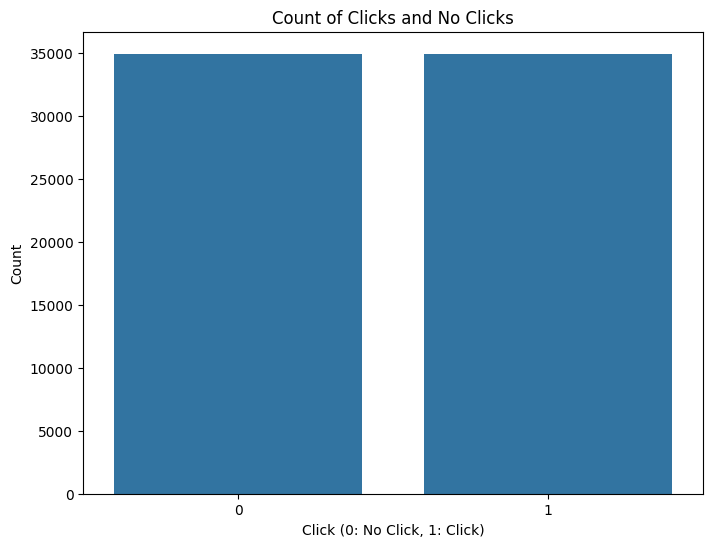

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count of clicks and no clicks
click_counts = df_preprocessed['click'].value_counts()
print(click_counts)

# Plot the count of clicks and no clicks
plt.figure(figsize=(8, 6))
sns.countplot(x='click', data=df_preprocessed)
plt.title('Count of Clicks and No Clicks')
plt.xlabel('Click (0: No Click, 1: Click)')
plt.ylabel('Count')
plt.show()

#### Task 2

Epoch: 0, Loss: 0.660537
Epoch: 1, Loss: 0.658049
Epoch: 2, Loss: 0.657936
Epoch: 3, Loss: 0.658071
Epoch: 4, Loss: 0.657877
Epoch: 5, Loss: 0.657898
Epoch: 6, Loss: 0.657989
Epoch: 7, Loss: 0.657716
Epoch: 8, Loss: 0.657780
Epoch: 9, Loss: 0.657878
Epoch: 10, Loss: 0.657932
Epoch: 11, Loss: 0.657954
Epoch: 12, Loss: 0.657898
Epoch: 13, Loss: 0.657781
Epoch: 14, Loss: 0.657892
Epoch: 15, Loss: 0.657847
Epoch: 16, Loss: 0.657775
Epoch: 17, Loss: 0.657762
Epoch: 18, Loss: 0.657756
Epoch: 19, Loss: 0.657930
Epoch: 20, Loss: 0.657803
Epoch: 21, Loss: 0.657888
Epoch: 22, Loss: 0.657778
Epoch: 23, Loss: 0.657844
Epoch: 24, Loss: 0.657923
Epoch: 25, Loss: 0.657883
Epoch: 26, Loss: 0.657996
Epoch: 27, Loss: 0.657918
Epoch: 28, Loss: 0.657892
Epoch: 29, Loss: 0.657949
Epoch: 30, Loss: 0.657911
Epoch: 31, Loss: 0.657845
Epoch: 32, Loss: 0.657888
Epoch: 33, Loss: 0.657872
Epoch: 34, Loss: 0.657913
Epoch: 35, Loss: 0.657944
Epoch: 36, Loss: 0.657873
Epoch: 37, Loss: 0.657977
Epoch: 38, Loss: 0.657

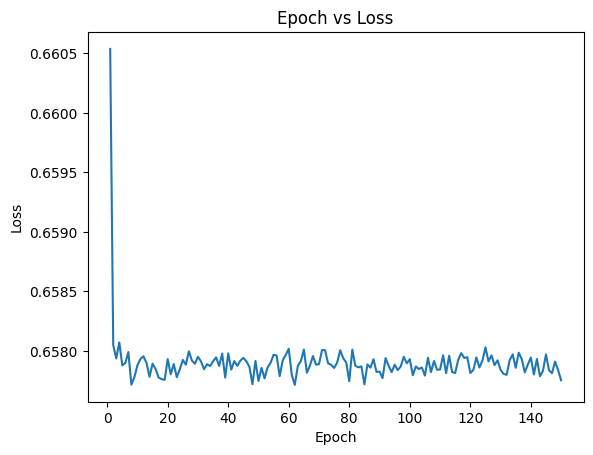

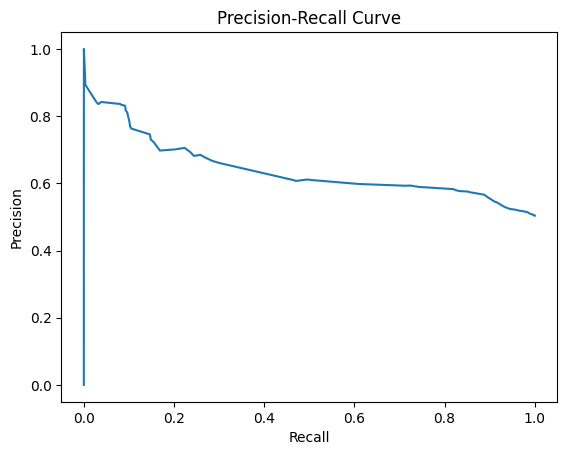

In [23]:
import torch
import numpy as np

# Check if GPU is available, else fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.001, num_epochs=100, batch_size=32):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

    def sigmoid(self, z):
        return 1 / (1 + torch.exp(-z))

    def loss(self, y, y_pred):
        return -torch.mean(y * torch.log(y_pred + 1e-15) + (1 - y) * torch.log(1 - y_pred + 1e-15))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = torch.zeros(num_features, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        losses = []

        for epoch in range(self.num_epochs):
            epoch_loss = 0.0

            # Shuffle data at the start of each epoch
            indices = torch.randperm(num_samples)
            X = X[indices]
            y = y[indices]

            for i in range(0, num_samples, self.batch_size):
                X_batch = X[i:i + self.batch_size].to(device)
                y_batch = y[i:i + self.batch_size].to(device)

                # Forward pass: Compute predictions
                z = torch.matmul(X_batch, self.weights) + self.bias
                y_pred = self.sigmoid(z)

                # Compute loss
                batch_loss = self.loss(y_batch, y_pred)
                epoch_loss += batch_loss.item()

                # Manually compute gradients
                error = y_pred - y_batch
                grad_W = torch.matmul(X_batch.T, error) / X_batch.shape[0]  # Gradient for weights
                grad_b = torch.mean(error)  # Gradient for bias

                # Update weights and bias using gradient descent
                self.weights -= self.learning_rate * grad_W
                self.bias -= self.learning_rate * grad_b

            avg_epoch_loss = epoch_loss / (num_samples // self.batch_size)
            losses.append(avg_epoch_loss)
            if epoch % 1 == 0:
                print(f"Epoch: {epoch}, Loss: {avg_epoch_loss:.6f}")

        return losses

    def predict_proba(self, X):
        X = X.to(device)
        z = torch.matmul(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).float()


X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

model = LogisticRegressionScratch(learning_rate=0.1, num_epochs=150, batch_size=128)
losses = model.fit(X_train, y_train)

# Print loss values at each epoch
for epoch, loss in enumerate(losses, start=1):
    print(f'Epoch {epoch}: Loss = {loss:.6f}')

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)

# Manual precision-recall calculation as before
thresholds = torch.linspace(0, 1, 100, device=device)
precision_list, recall_list = [], []

for threshold in thresholds:
    preds = (y_pred_proba >= threshold).float()
    TP = (preds * y_test).sum()
    FP = (preds * (1 - y_test)).sum()
    FN = ((1 - preds) * y_test).sum()

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)

    precision_list.append(precision.item())
    recall_list.append(recall.item())


# Plot epoch vs loss
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.show()

# Plot precision-recall curve
plt.plot(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [22]:
y_pred_proba_cpu = y_pred_proba.cpu().detach()
y_test_cpu = y_test.cpu().detach()

# Convert probabilities to class labels using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_cpu = (y_pred_proba_cpu > threshold).float()

# Calculate evaluation metrics

# AUC-ROC Calculation
def compute_auc_roc(y_true, y_scores):
    sorted_indices = torch.argsort(y_scores, descending=True)
    y_true_sorted = y_true[sorted_indices]
    tpr = torch.cumsum(y_true_sorted, dim=0) / torch.sum(y_true_sorted)
    fpr = torch.cumsum(1 - y_true_sorted, dim=0) / (len(y_true) - torch.sum(y_true))
    auc = torch.trapz(tpr, fpr)
    return auc.item()


# Accuracy Calculation
def compute_accuracy(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    total = y_true.size(0)
    return correct / total

# Precision Calculation
def compute_precision(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum().item()
    fp = ((y_true == 0) & (y_pred == 1)).sum().item()
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

# Recall Calculation
def compute_recall(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum().item()
    fn = ((y_true == 1) & (y_pred == 0)).sum().item()
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# F1-Score Calculation
def compute_f1(y_true, y_pred):
    precision = compute_precision(y_true, y_pred)
    recall = compute_recall(y_true, y_pred)
    return (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

# Calculate metrics
auc_roc = compute_auc_roc(y_test_cpu, y_pred_proba_cpu)
accuracy = compute_accuracy(y_test_cpu, y_pred_cpu)
precision = compute_precision(y_test_cpu, y_pred_cpu)
recall = compute_recall(y_test_cpu, y_pred_cpu)
f1 = compute_f1(y_test_cpu, y_pred_cpu)

# Print results
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

AUC-ROC: 0.6490
Accuracy: 0.6009
Precision: 0.5993
Recall: 0.6270
F1-Score: 0.6128
